cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

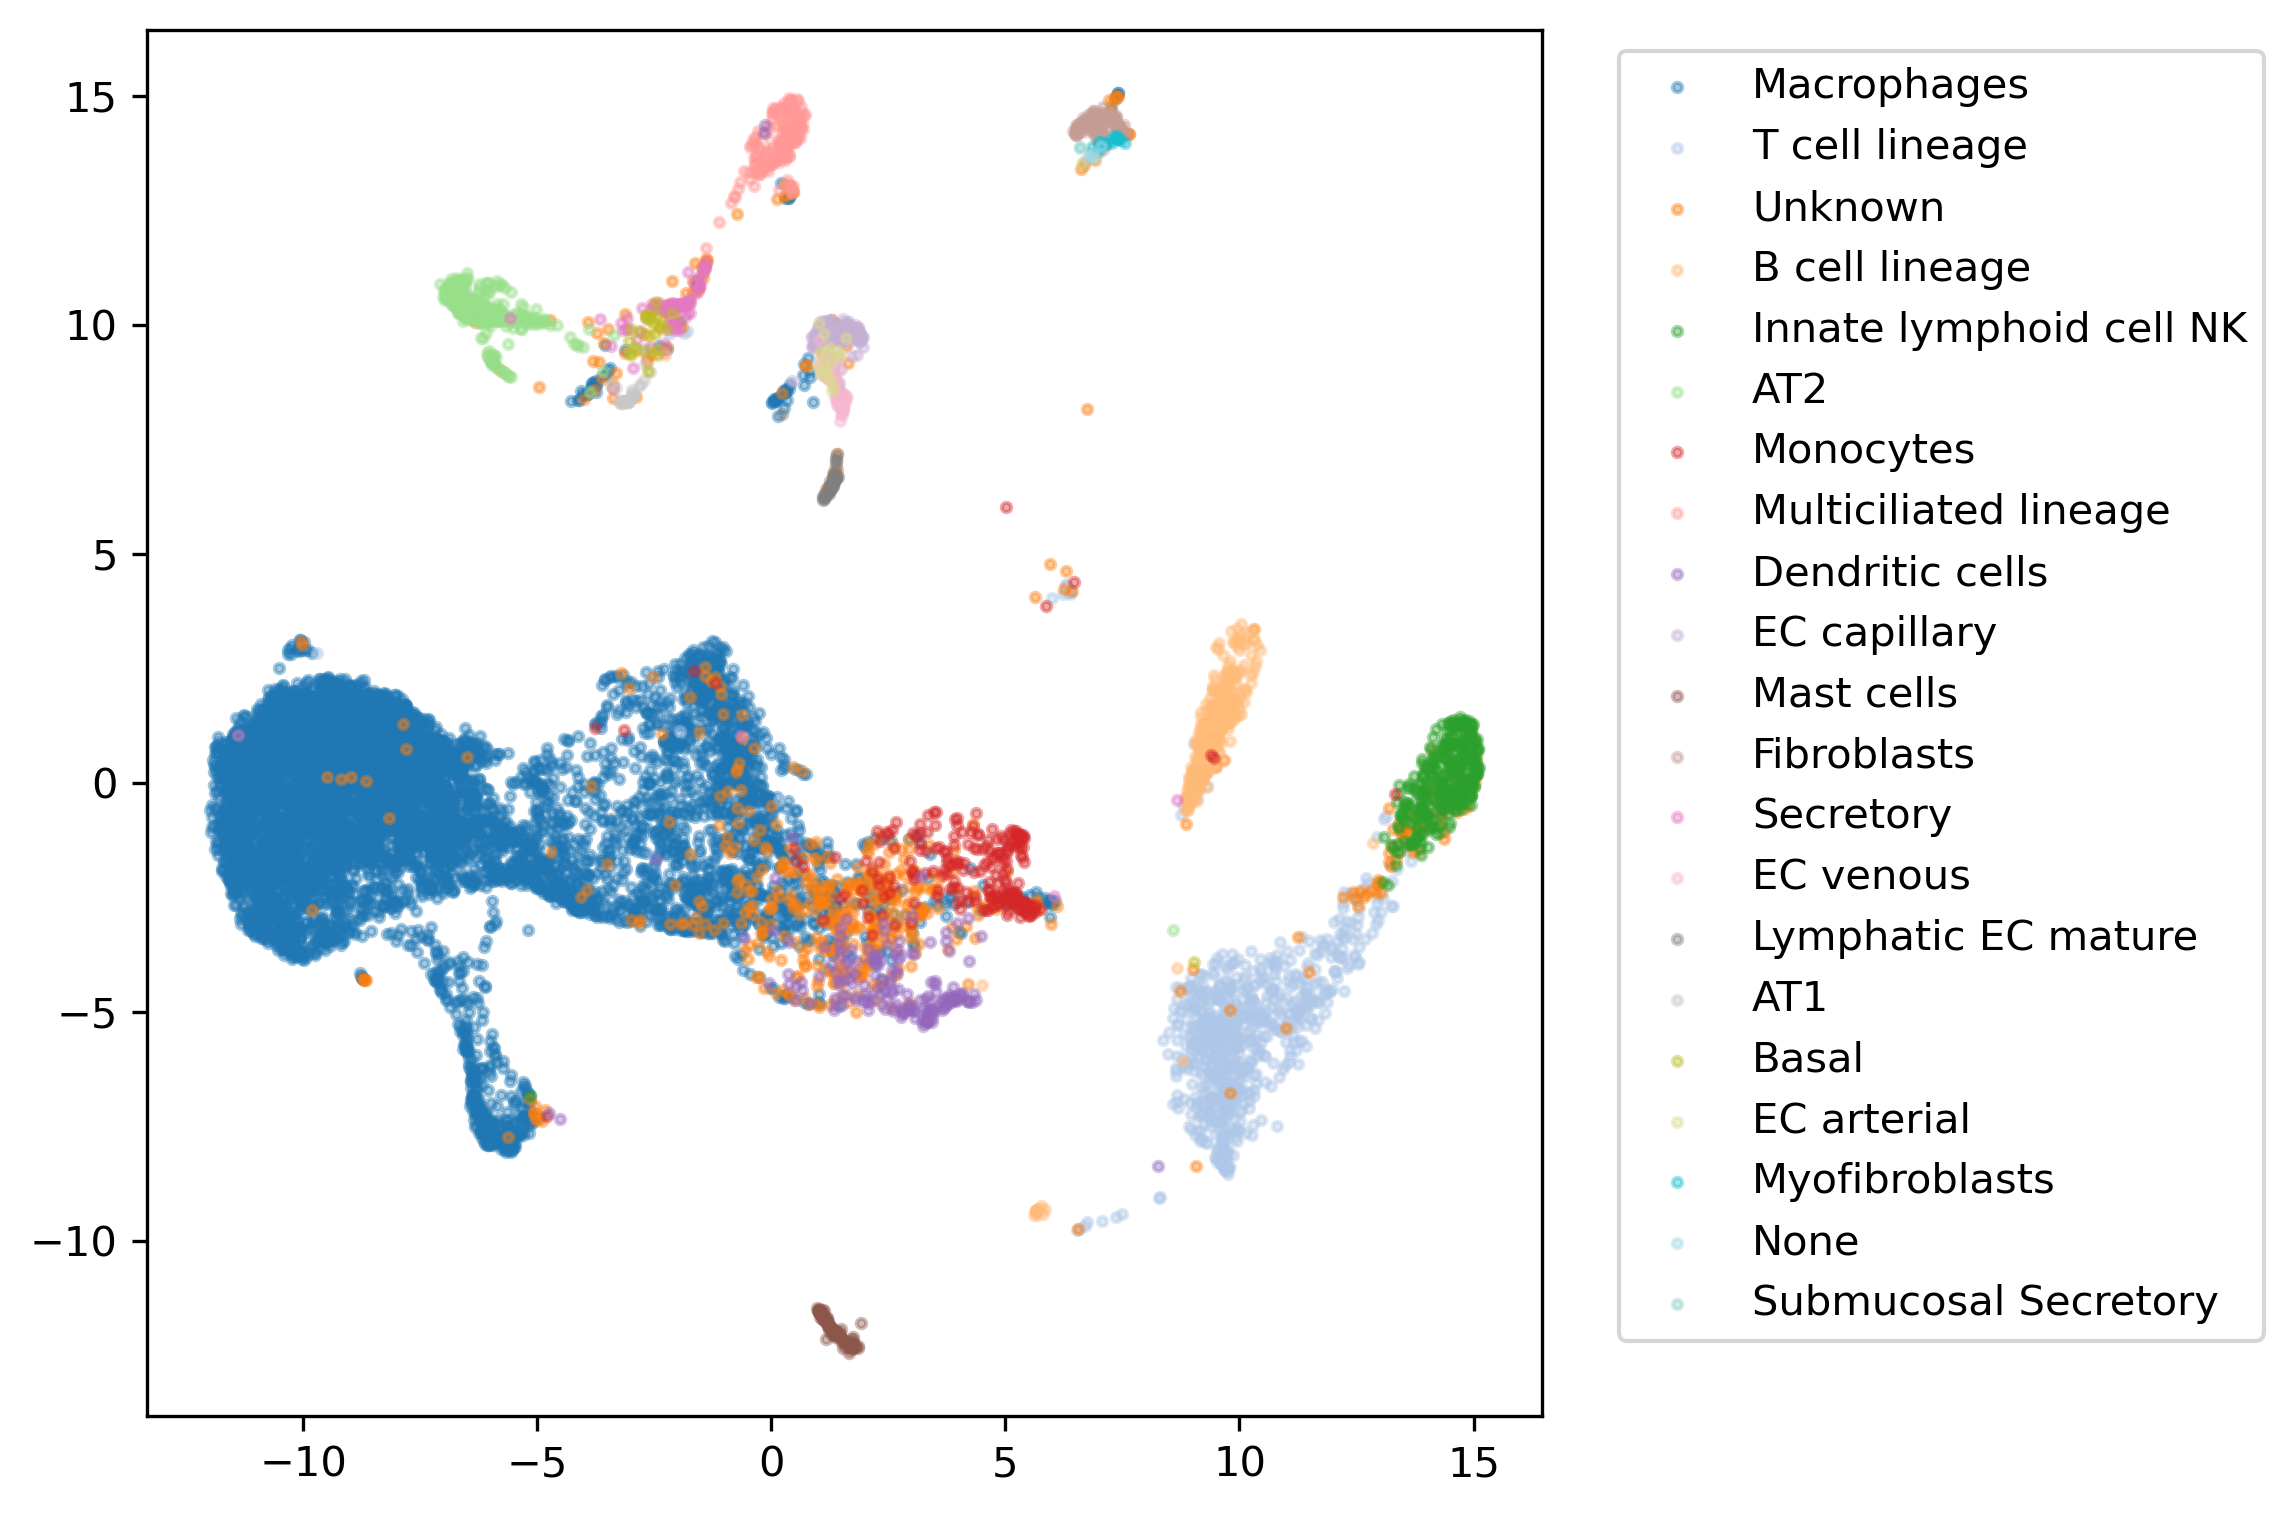

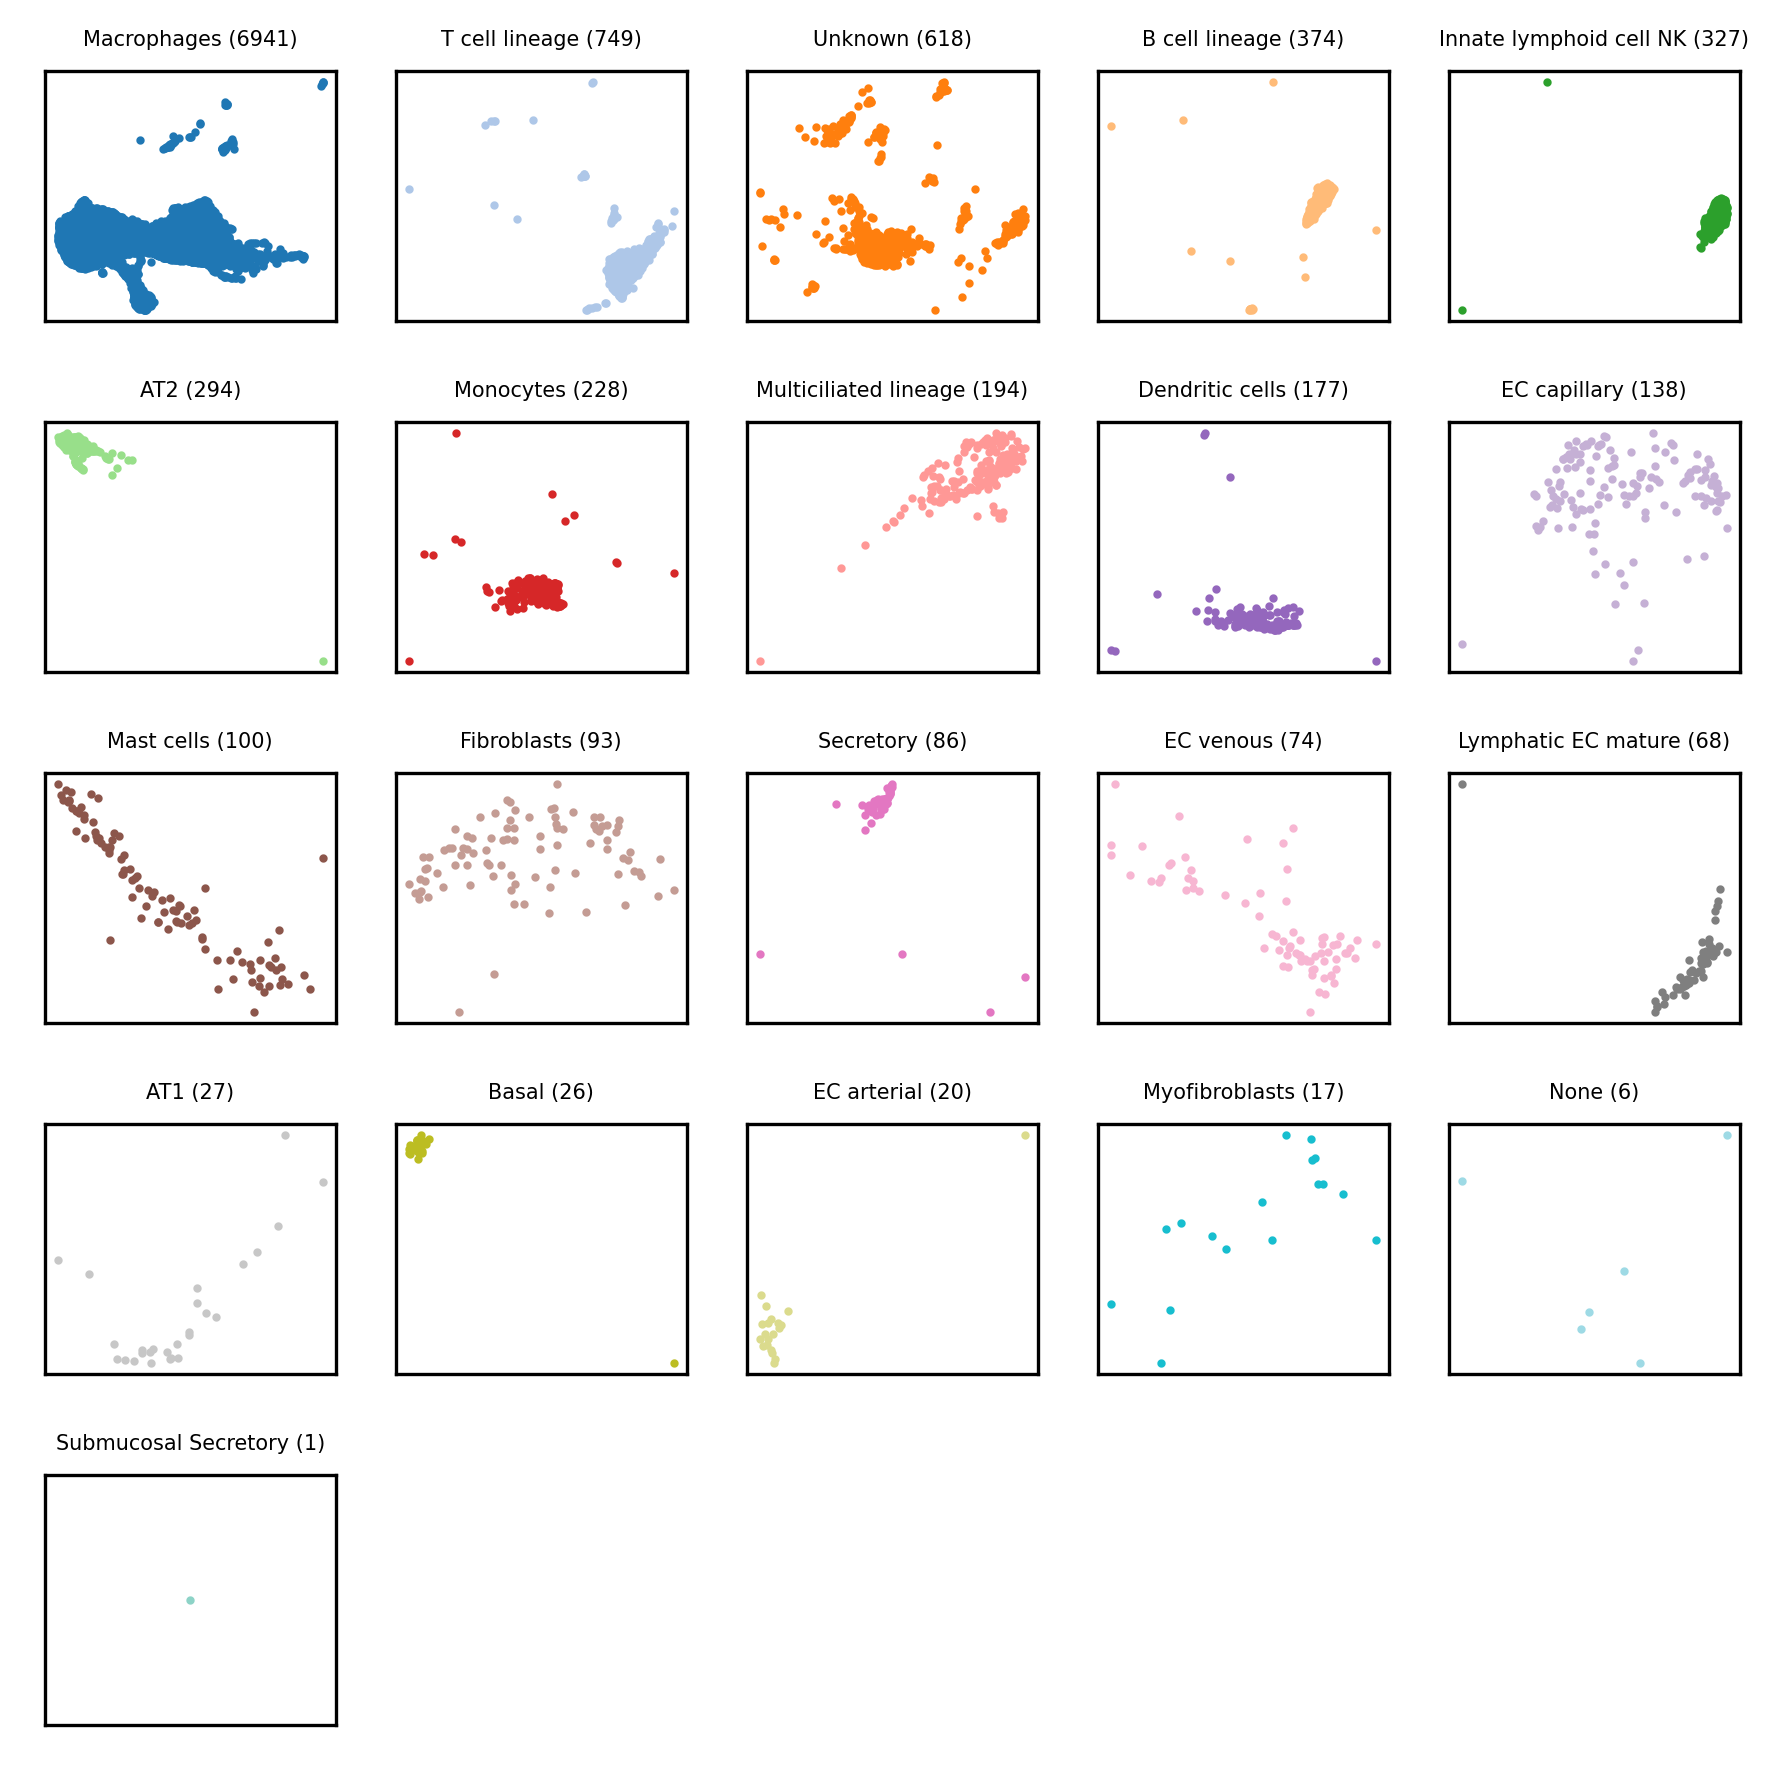

In [1]:
import numpy as np
import seaborn as sns
import torch

import umap
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
import matplotlib

import utils
import plots
from model_AE import reduction_AE
from model_GAT import Encoder,SenGAE,train_GAT
from model_Sencell import Sencell

def umapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    plt.figure(figsize=(6,6),dpi=300)
    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        for i,(cluster,label) in enumerate(zip(clusters,labels)):
            plt.scatter(embedding[cluster,0],embedding[cluster,1],alpha=0.4,s=5,color=color_ls[i],label=label)
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        

def subUmapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    fig, axes = plt.subplots(5, 5, sharex=False, sharey=False,figsize=(6,6),dpi=300)

    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        x_s=[]
        y_s=[]
        label_s=[]
        for cluster,label in zip(clusters,labels):
            x_s.append(embedding[cluster,0])
            y_s.append(embedding[cluster,1])
            label_s.append(label)
        count=0
        for i, row in enumerate(axes):
            for j, col in enumerate(row):
                if count<21:
                    col.scatter(x_s[count],y_s[count],alpha=1,color=color_ls[count],s=1)
                    col.set_title(f"{label_s[count]} ({len(clusters[count])})",fontsize=5)
                    count+=1
                else:
                    col.set_visible(False)
    plt.setp(fig.axes, yticks=[],xticks=[])
    
    plt.tight_layout()

        
    # plt.savefig("umap.svg",format='svg')

# Part 1: load and process data
data_path="/users/PCON0022/haocheng/Basu_lab/rmarkdown/SCB01S5.h5ad"
# cell_cluster_arr在画umap的时候用
adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data(data_path)
umapPlot(adata.obsm['X_umap'],clusters=cluster_cell_ls,labels=celltype_names)
subUmapPlot(adata.obsm['X_umap'],clusters=cluster_cell_ls,labels=celltype_names)

In [2]:
new_data,markers_index,\
sen_gene_ls,nonsen_gene_ls,gene_names=utils.process_data(adata,cluster_cell_ls,cell_cluster_arr)

print(f'cell num: {new_data.shape[0]}, gene num: {new_data.shape[1]}')

gene_cell=new_data.X.toarray().T
graph_nx=utils.build_graph_nx(gene_cell,cell_cluster_arr,sen_gene_ls,nonsen_gene_ls,gene_names)
print("Part 1, data loading and processing end!")

# Part 2: generate init embedding
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ',device)

retrain=False
if retrain:
    gene_embed,cell_embed=reduction_AE(gene_cell,device)
    print(gene_embed.shape,cell_embed.shape)
    torch.save(gene_embed,'./gene.emb')
    torch.save(cell_embed,'./cell.emb')
else:
    gene_embed=torch.load('./gene.emb')
    cell_embed=torch.load('./cell.emb')

graph_nx=utils.add_nx_embedding(graph_nx,gene_embed,cell_embed)

各marker list所包含的gene数：
  Markers1    Markers2    Markers3    Markers4
----------  ----------  ----------  ----------
       126          78         145          84
total marker genes:  380
highly_genes num:  2000
After highly genes dropped duplicate:  1894
Total gene num: 2245
cell num: 10558, gene num: 2245
The number of edges: 1745053
Part 1, data loading and processing end!
device:  cuda:0


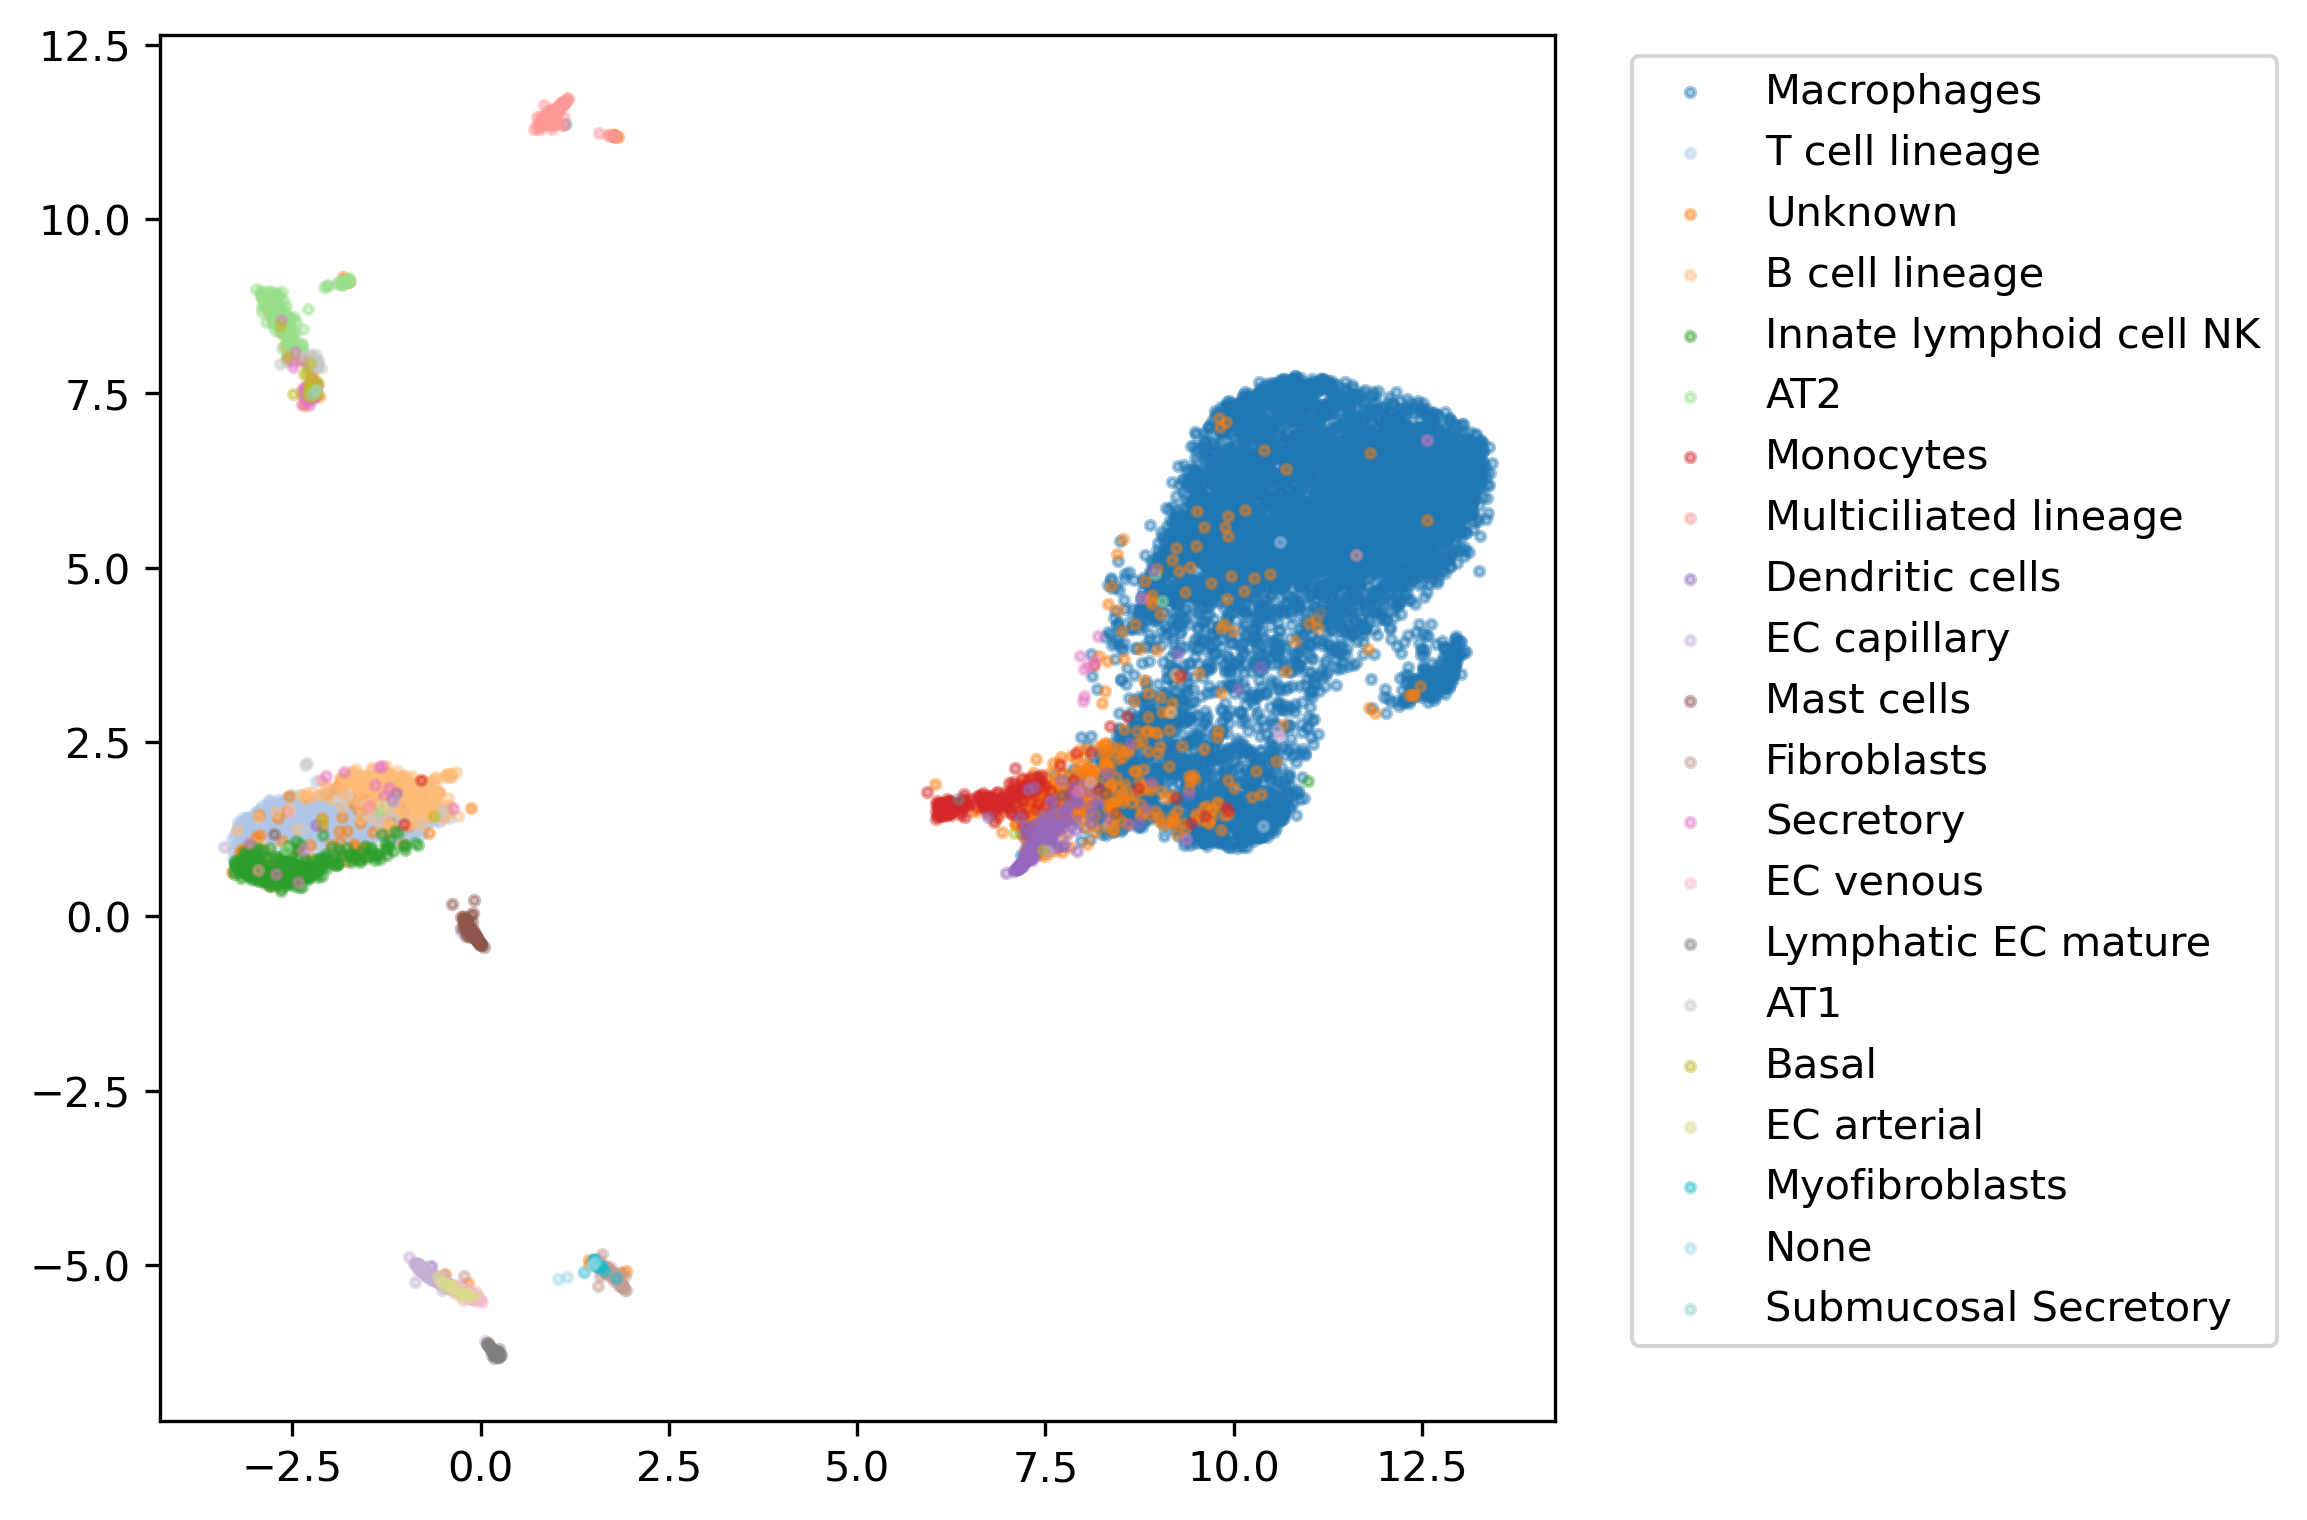

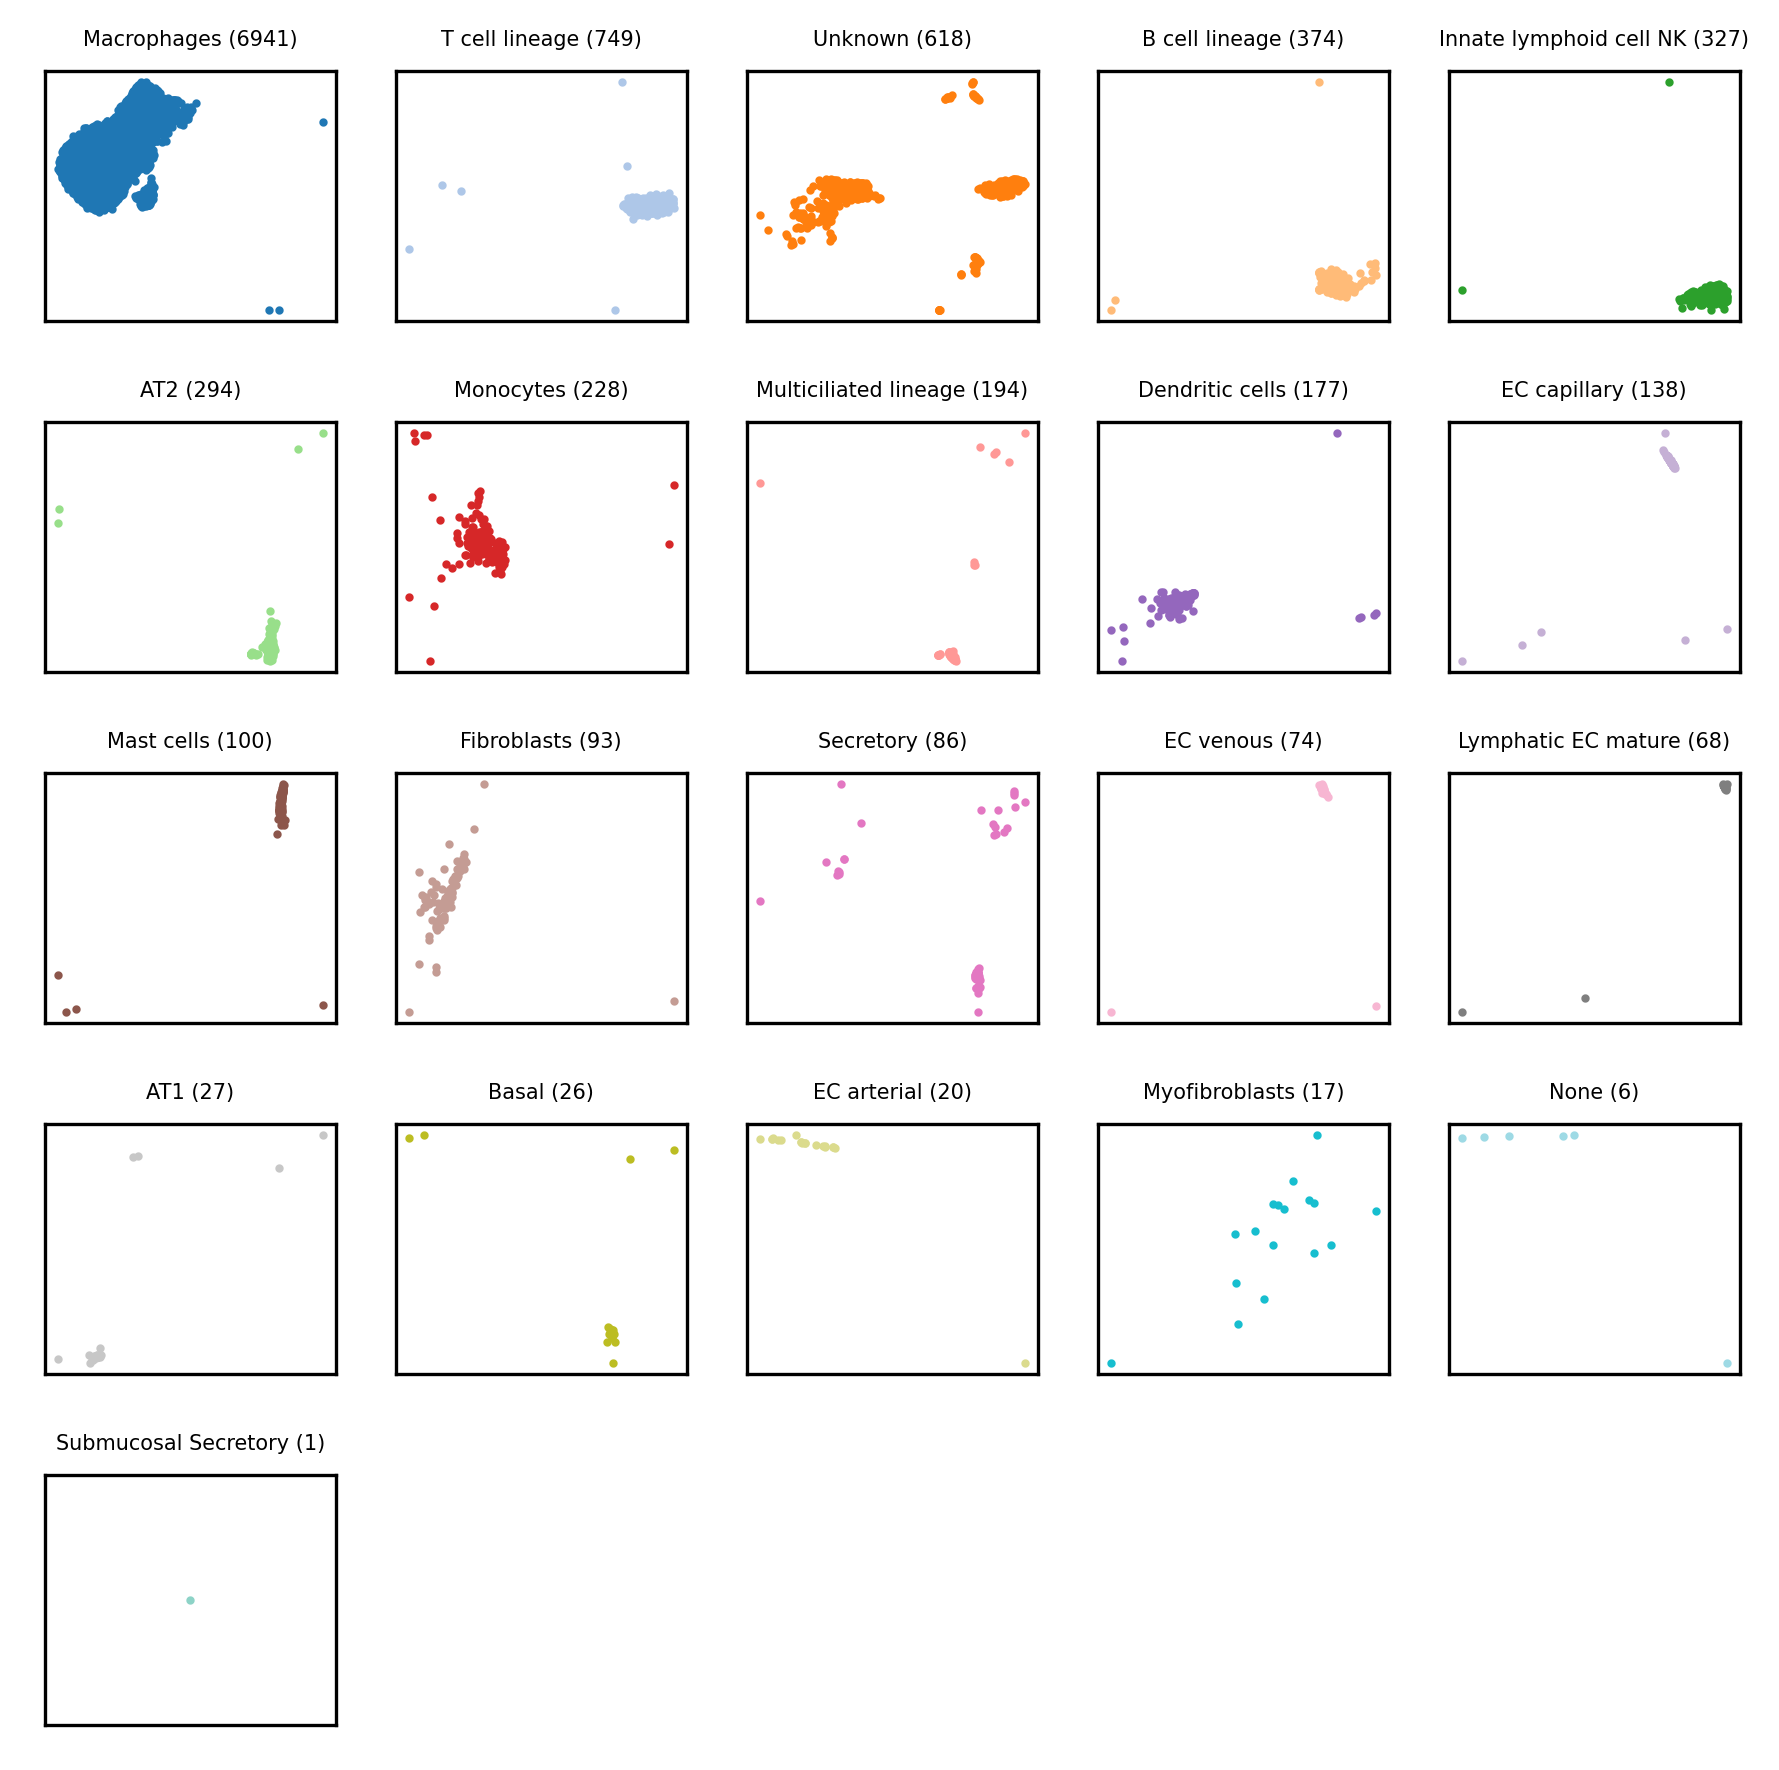

In [3]:
umapPlot(cell_embed.cpu().detach().numpy(),reduce=True,
         clusters=cluster_cell_ls,labels=celltype_names)
subUmapPlot(cell_embed.cpu().detach().numpy(),reduce=True,
         clusters=cluster_cell_ls,labels=celltype_names)

In [4]:
graph_nx=utils.add_nx_embedding(graph_nx,gene_embed,cell_embed)
graph_pyg=utils.build_graph_pyg(gene_cell,gene_embed,cell_embed)
print("Part 2, AE end!")

# Part 3: train GAT
# graph_pyg=graph_pyg.to('cpu')
GAT_model=train_GAT(graph_nx,graph_pyg,device,retrain=False,resampling=False)
print("Part 3, training GAT end!")

the number of edges: 1745053
edge index:  torch.Size([2, 1745053])
node feature:  torch.Size([12803, 128])
Pyg graph: Data(x=[12803, 128], edge_index=[2, 3490106], y=[12803])
graph.is_directed(): False
Part 2, AE end!
Part 3, training GAT end!


In [32]:
def get_embeddings(model_GAT,graph_pyg,device):
    model_GAT.eval() 
    model_GAT.to(device)
    graph_pyg.to(device)
    
    # 这里要求graph_pyg要有y属性表示节点类型
    result=model_GAT(graph_pyg)
    
    return result


a=get_embeddings(GAT_model,graph_pyg,'cpu')

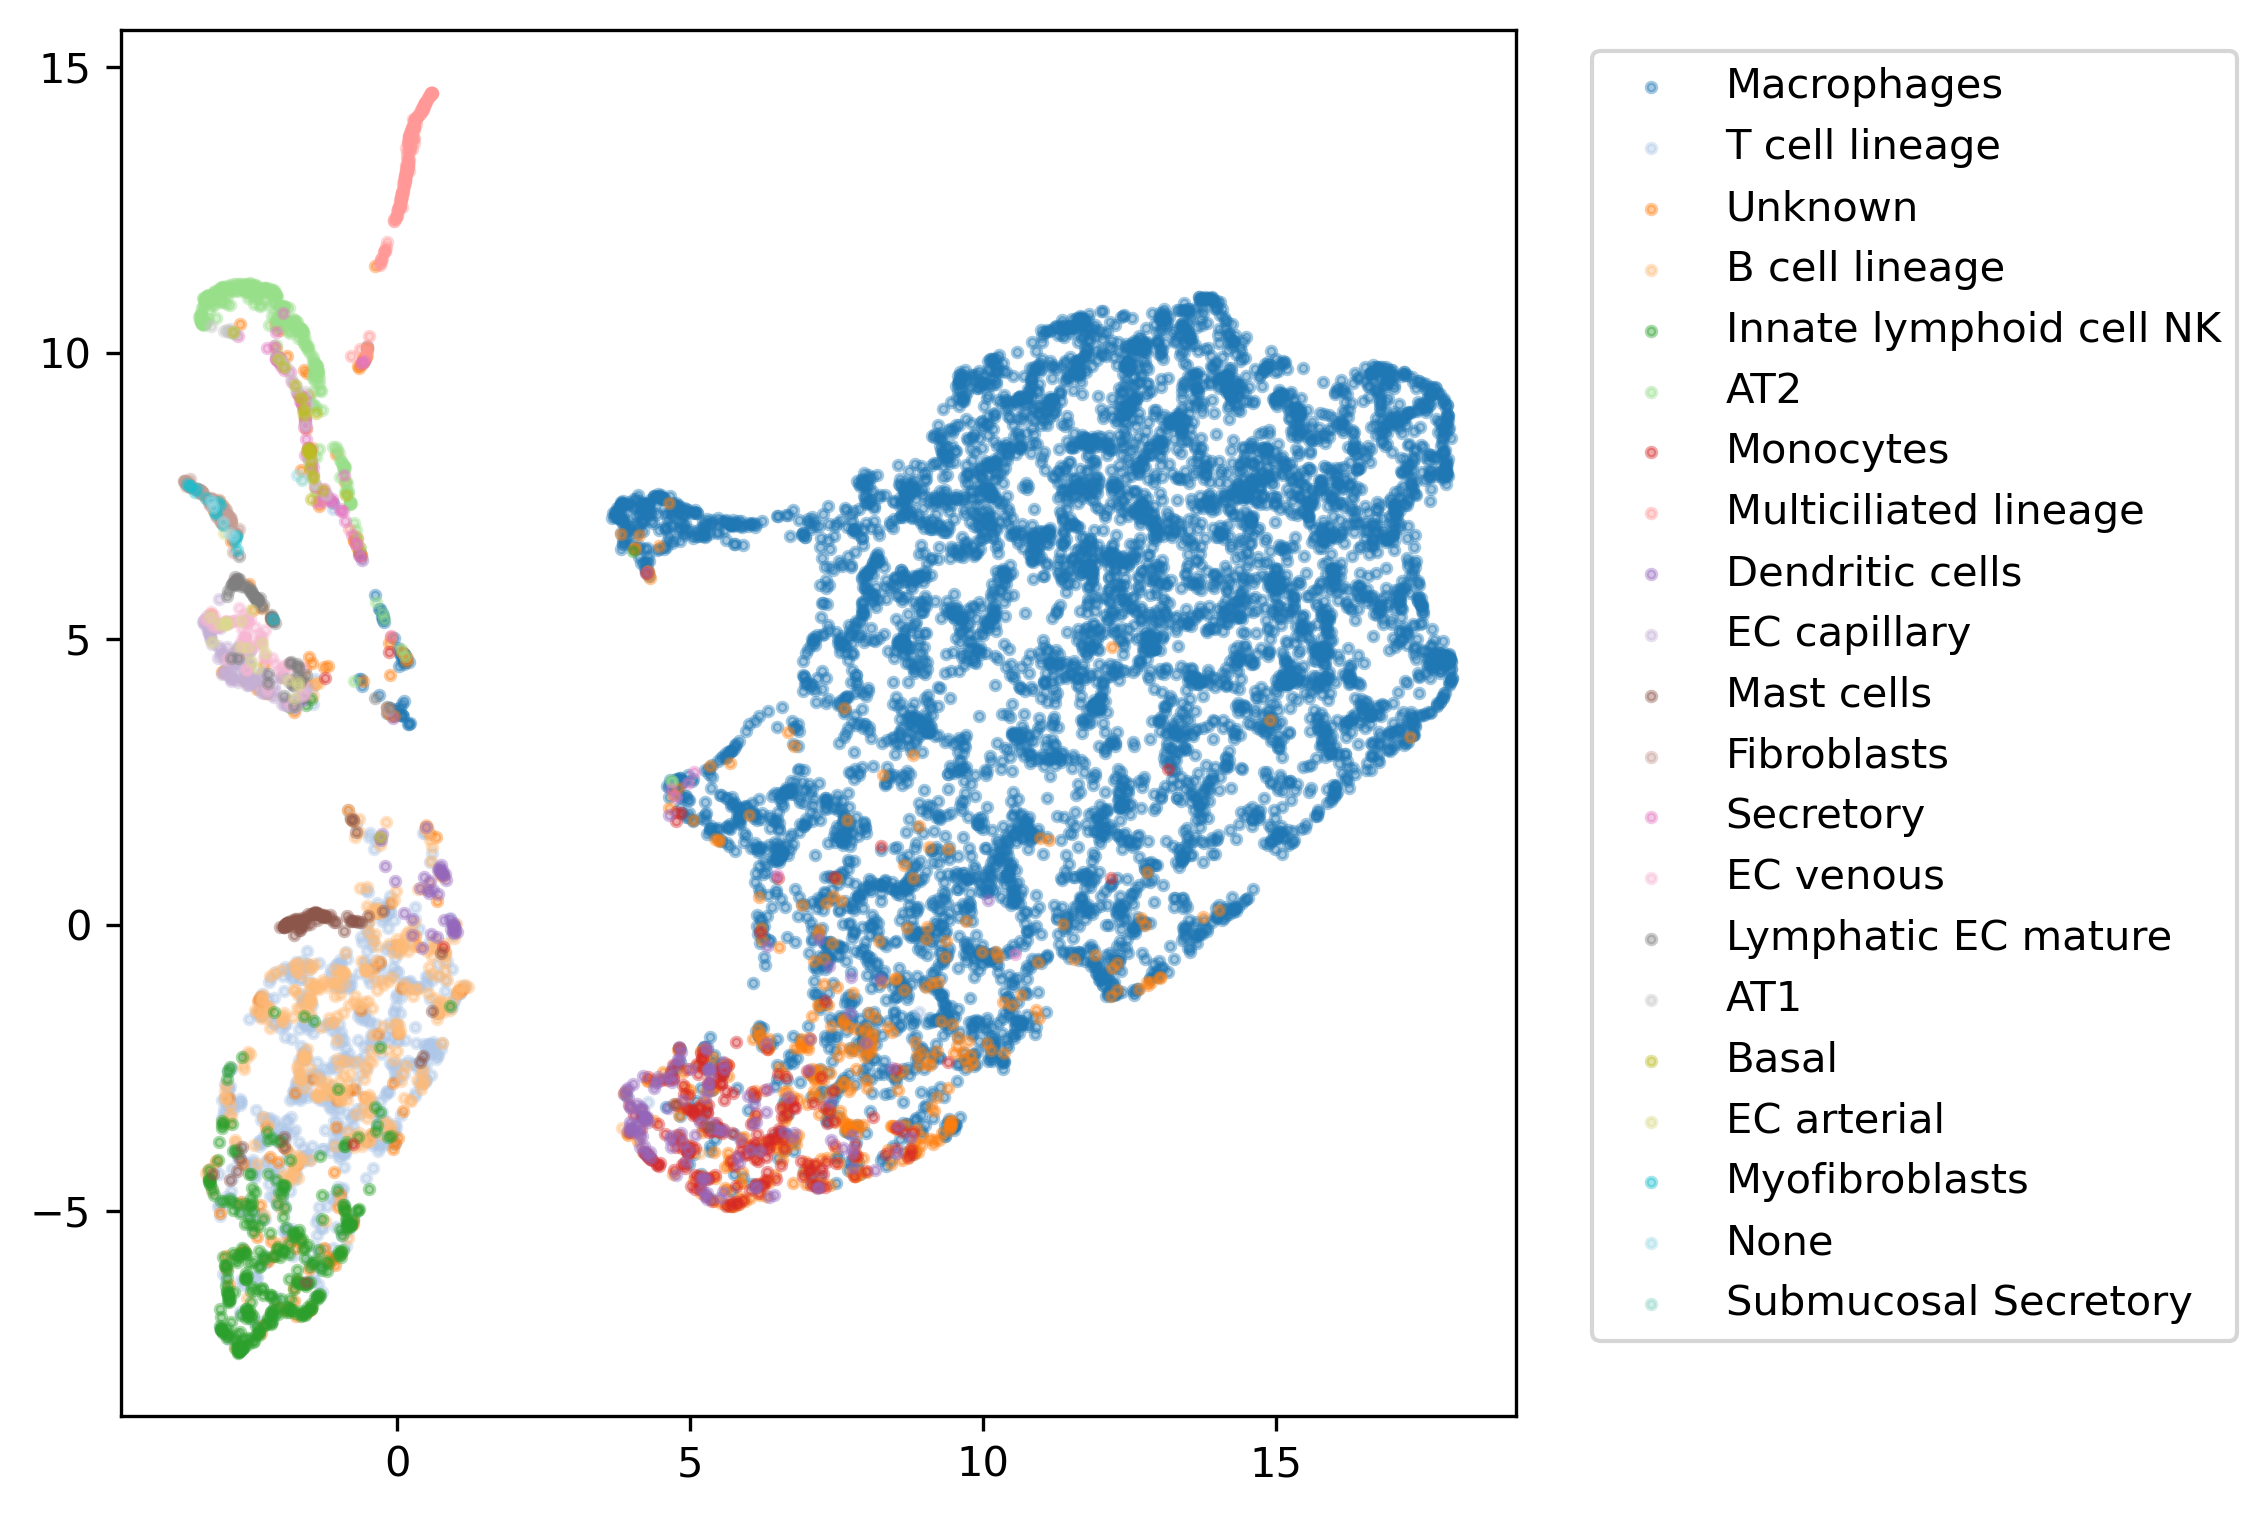

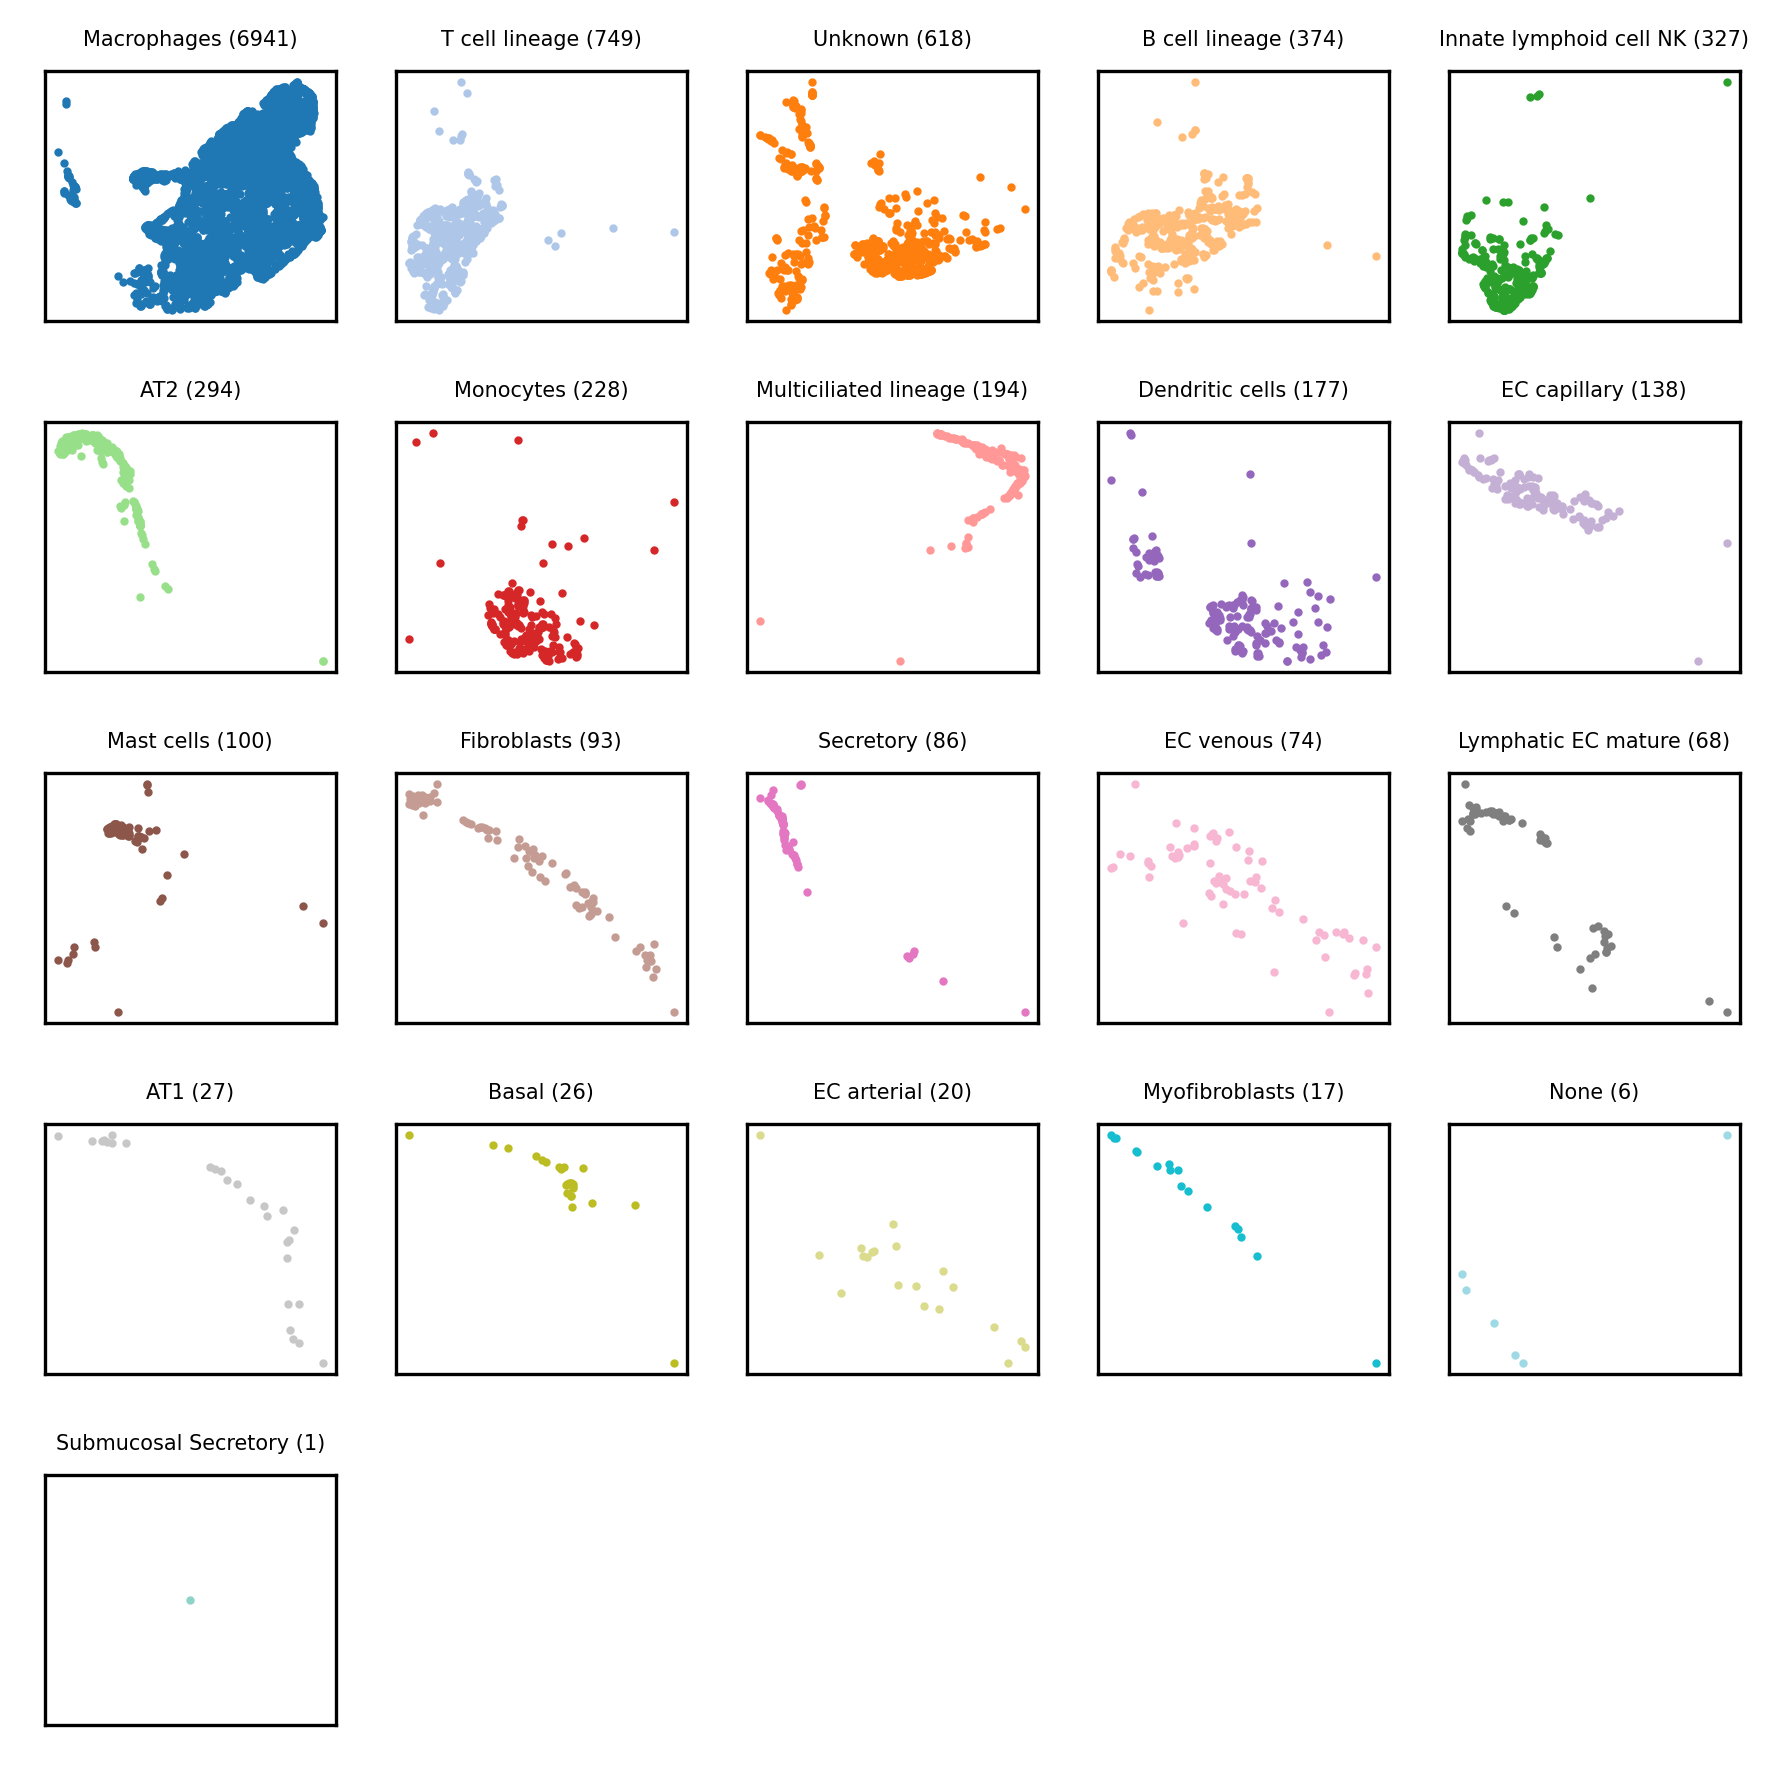

In [39]:
cell_embed=a[torch.bitwise_not(graph_pyg.y),:].detach().numpy()
umapPlot(cell_embed,reduce=True,
         clusters=cluster_cell_ls,labels=celltype_names)
subUmapPlot(cell_embed,reduce=True,
         clusters=cluster_cell_ls,labels=celltype_names)

In [31]:
from torch.nn import functional as F

def test(graph,model):
    model.eval() 
    model.to('cpu')
    graph.to('cpu')
    
    x, edge_index,y = graph.x, graph.edge_index, graph.y
    
    x_gene=F.relu(model.encoder.linear1(x[y,:]))
    x_cell=F.relu(model.encoder.linear2(x[torch.bitwise_not(y),:]))
    x=model.encoder.cat(x_gene,x_cell,y)
    x = model.encoder.conv1(x, edge_index)
#     x = F.relu(x)
    print(x)
#     x_gene=F.relu(self.linear1(x[y,:]))
#     x_cell=F.relu(self.linear2(x[torch.bitwise_not(y),:]))
#     x=self.cat(x_gene,x_cell,y)

#     x = self.conv1(x, edge_index)
#     # x = F.relu(x)
#     x = self.act(x)
#     x = F.dropout(x, training=self.training)
#     x = self.conv2(x, edge_index)
#     x = self.act(x)

test(graph_pyg,GAT_model)

tensor([[ 0.1144,  0.1978,  0.0288,  ..., -0.0120, -0.0052, -0.1700],
        [ 0.2634,  0.2982,  0.2485,  ..., -0.0767,  0.6926, -0.0375],
        [ 0.3008,  0.1910,  0.2948,  ..., -0.1585,  0.1724, -0.0019],
        ...,
        [ 0.1158,  0.0750,  0.1038,  ...,  0.2529,  1.0211,  0.3199],
        [-0.2529, -0.0734, -0.1173,  ..., -0.0225, -0.1366,  0.1018],
        [-0.1478, -0.0358, -0.1172,  ..., -0.0056, -0.0256,  0.0875]],
       grad_fn=<AsStridedBackward>)


Linear(in_features=128, out_features=128, bias=True)

In [6]:
a

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<CeluBackward0>)

In [9]:
for name, parms in GAT_model.named_parameters():
    print('-->name:', name)
    print('-->para:', parms)

-->name: encoder.linear1.weight
-->para: Parameter containing:
tensor([[-0.0007, -0.0002,  0.0085,  ..., -0.0004,  0.0002, -0.0027],
        [-0.0201,  0.0095, -0.0117,  ...,  0.0026, -0.0587,  0.0009],
        [-0.0012, -0.0102,  0.0323,  ...,  0.0027,  0.0079, -0.0407],
        ...,
        [ 0.0002, -0.0350,  0.0056,  ...,  0.0073,  0.0595, -0.0262],
        [-0.0184,  0.0402,  0.0093,  ..., -0.0503,  0.0559,  0.0588],
        [-0.0270,  0.0198, -0.0099,  ...,  0.0218, -0.0184,  0.0667]],
       device='cuda:0', requires_grad=True)
-->name: encoder.linear1.bias
-->para: Parameter containing:
tensor([-1.9560e-04, -1.5451e-02,  1.4241e-03, -8.1913e-03, -5.7881e-02,
         1.1208e-02,  2.7280e-02, -2.8121e-03,  2.1171e-02, -4.1105e-03,
         3.8018e-03,  1.2437e-02, -1.3246e-02, -2.7022e-02,  7.4024e-02,
         1.8429e-02,  4.5742e-06,  7.1711e-03, -2.0929e-02,  8.4668e-03,
         6.7822e-03,  2.7486e-02, -2.8312e-02, -4.9878e-03,  6.9303e-02,
        -3.3813e-03,  1.2040e-03,

In [39]:
new_data

View of AnnData object with n_obs × n_vars = 10558 × 2245
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.ribo', 'percent.mito', 'feature.mad.higher', 'ribo.mad.higher', 'integrated_snn_res.0.1', 'seurat_clusters', 'X', 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'

In [46]:
adata_gene_names=list(adata.var.index)
gene_indexs=[adata_gene_names.index(name) for name in gene_names]

'VCAM1'

'KLHL4'

In [41]:
new_data.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable
HES4,0.026899,0.042849,0.032155,1.332579,True
ISG15,0.348740,0.867665,0.476163,1.822200,True
TTLL10,0.014113,0.027934,0.017088,1.634712,True
TNFRSF18,0.013639,0.027473,0.016499,1.665189,True
TNFRSF4,0.012881,0.058752,0.015556,2.806782,True
...,...,...,...,...,...
TFF1,0.000284,0.000474,0.000287,1.330008,True
AC000082.1,0.000474,0.000663,0.000486,1.362738,True
IGLV6-57,0.002178,0.023771,0.002358,2.045124,True
IGLV3-21,0.005778,0.161281,0.006657,2.047396,True


In [10]:
a

array([9, 9, 9, 4])